In [1]:
!pip install --upgrade --force-reinstall git+https://github.com/FelipeSchreiber/BregmanClustering.git
!chmod 777 /usr/local/lib/python3.9/dist-packages/BregmanTests/install_algos.sh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/FelipeSchreiber/BregmanClustering.git to /tmp/pip-req-build-1uxp9w9l
  Running command git clone --filter=blob:none --quiet https://github.com/FelipeSchreiber/BregmanClustering.git /tmp/pip-req-build-1uxp9w9l
  Resolved https://github.com/FelipeSchreiber/BregmanClustering.git to commit de7462cbf371b49203371bf0d4cbfde51acfc27a
  Preparing metadata (setup.py) ... done
  Using cached torch_geometric-2.3.0-py3-none-any.whl
  Using cached rpy2-3.5.1-cp39-cp39-linux_x86_64.whl
  Using cached tzlocal-4.3-py3-none-any.whl (20 kB)
  Using cached pytz-2023.3-py2.py3-none-any.whl (502 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached cffi-1.15.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (441 kB)
  Using cached requests-2.28.2-py3-none-any.whl (62 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached scipy-1.10.1-

In [2]:
from BregmanTests.install_algorithms import main as install_env
## Optional: set repository for CRAN
BregmanTests.cfg.CRAN_repo = "https://cran.fiocruz.br/"
install_env()


Installing R packages...



(as ‘lib’ is unspecified)

















	‘/tmp/RtmpOw2ZaR/downloaded_packages’



In [3]:
%matplotlib inline
from BregmanTests.WSBM import *
from BregmanTests.utils import *
import BregmanTests
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score
#from signet.cluster import Cluster
import scipy.sparse as ss
import pandas as pd
from CSBM.Python.functions import *
import os
import warnings
from BregmanClustering import models
from BregmanClustering.models import SoftBregmanNodeAttributeGraphClustering as VEMbreg
from BregmanClusteringTorch.torch_models import SoftBregmanClusteringTorch as torchBreg
import subprocess
warnings.filterwarnings("ignore")

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 17 17:08:00 2023

@author: maximilien, Felipe Schreiber
"""
from tqdm import tqdm

In [5]:
c = 3 ## number of communities
n = 100 ##size per community (or you can pass a list with different sizes)
r = 10 ##specify how far the attributes distributions are from the origin
d = 2 ##number of attributes
P = np.array([[0.8, 0.2, 0.3],[0.2, 0.7, 0.4],[0.3, 0.4, 0.6]])

In [6]:
X,Y,true_labels = BregmanBenchmark(P,[n]*c,1,10,dims=d,weight_variance=0.01,att_variance=0.1,\
                       weight_distribution="logistic",attributes_distribution="logistic",radius=r).generate_benchmark_WSBM()
A = (X != 0).astype(int)

In [7]:
X

array([[0.        , 1.0524723 , 1.03625291, ..., 0.        , 4.43713739,
        0.        ],
       [1.0524723 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.03625291, 0.        , 0.        , ..., 4.55750478, 0.        ,
        4.69439932],
       ...,
       [0.        , 0.        , 4.55750478, ..., 0.        , 0.        ,
        9.91486628],
       [4.43713739, 0.        , 0.        , ..., 0.        , 0.        ,
        9.90420817],
       [0.        , 0.        , 4.69439932, ..., 9.91486628, 9.90420817,
        0.        ]])

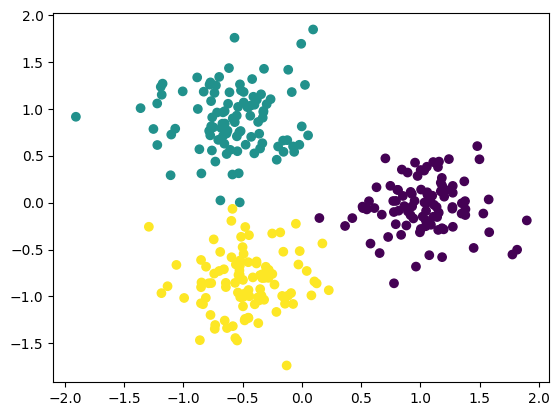

In [8]:
plt.scatter(Y[:,0],Y[:,1],c=true_labels)

In [9]:
pred_labels = spectral(X.copy(),c)
print(adjusted_rand_score(true_labels, pred_labels),normalized_mutual_info_score(true_labels, pred_labels))

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f9db45c3dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.9/dist-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/usr/local/lib/python3.9/dist-packages/threadpoolctl.py", line 842, in __init__
    super().__init__(**kwargs)
  File "/usr/local/lib/python3.9/dist-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.9/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error


1.0 1.0


In [10]:
pred_labels = GaussianMixture(n_components=c).fit_predict(Y.copy())
print(adjusted_rand_score(true_labels, pred_labels),normalized_mutual_info_score(true_labels, pred_labels))

0.9799166810177865 0.9659698982538929


In [11]:
model = torchBreg(n_clusters=c,normalize_=True,thresholding=True)
model.fit(A, Y)
z_pred_both = model.predict(A,Y)
print(adjusted_rand_score(true_labels, z_pred_both),normalized_mutual_info_score(true_labels, z_pred_both))

Initialisation chosen from the graph
0
1.0 1.0


In [15]:
n_average = 1
n = 300
n_clusters = 2
d = 1
sizes = [ n // n_clusters ]*np.ones( n_clusters, dtype = int )

b = 5
pout = b * np.log( n ) / n

a_range = [ 5,7,9,11,13,15 ]
r_range = [ 0,1,2,3,4,5 ]
# a_range = [ 5,7,9]
# r_range = [ 0,1,2]

stats = {"varying":[],"a":[],"r":[],"agreed":[],"ARI_chernoff":[],"ARI_AIC":[],"ARI_ORACLE":[]}

for varying in ["attributes","graph"]:
# varying = 'attributes'
# #varying = 'graph'

    aris_attributes_mean = [ ]
    aris_graph_mean = [ ]
    aris_both_mean = [ ]
    aris_attSBM_mean = [ ]
    aris_IR_sLS_mean = [ ]
    aris_IR_LS_mean = [ ]
    aris_both2_mean = [ ]
    aris_oracle_mean = [ ]

    aris_attributes_std = [ ]
    aris_graph_std = [ ]
    aris_both_std = [ ]
    aris_attSBM_std = [ ]
    aris_IR_sLS_std = [ ]
    aris_IR_LS_std = [ ]
    aris_both2_std = [ ]
    aris_oracle_std = [ ]

    if varying == 'graph':
        loop = tqdm( range( len( a_range ) ) )
    else:
        loop = tqdm( range( len( r_range ) ) )

    for dummy in loop:
        if varying == 'graph':
            a = a_range[ dummy ]
            r = 1
        elif varying == 'attributes':
            a = 8
            r = r_range[ dummy ]

        pin = a * np.log( n ) / n
        p = (pin- pout) * np.eye( n_clusters ) + pout * np.ones( (n_clusters, n_clusters) )

        aris_attributes = [ ]
        aris_graph = [ ]
        aris_both = [ ]
        aris_attSBM = [ ]
        aris_IR_sLS  = [ ]
        aris_IR_LS = [ ]
        aris_both2 = [ ]
        aris_oracle = [ ]
        
        path_ = BregmanTests.cfg.path_to_data+f"a/{a}/r/{r}/"
        if not os.path.exists(path_):
            os.makedirs(path_)

        total = 0
        for trial in range( n_average ):
            ( X, Y, z_true ) = BregmanBenchmark(p,sizes,att_variance=1,\
                    attributes_distribution="gaussian",radius=r).generate_benchmark_WSBM()
            
            X = (X != 0).astype(int)
            model = models.BregmanNodeAttributeGraphClustering( n_clusters = n_clusters, initializer="chernoff")
            ## For comparison purposes, the initialization is the same for IR-sLS, IR-LS and ours    
            model.initialize(X,Y)
            model.assignInitialLabels( X, Y )
            z_init = model.predicted_memberships
            chernoff_init_graph = model.graph_init
            chernoff_graph_labels = model.memberships_from_graph
            chernoff_att_labels = model.memberships_from_attributes

            with open(f'{path_}att_{trial}.npy', 'wb') as g:
                np.save(g, Y)
            with open(f'{path_}net_{trial}.npy', 'wb') as g:
                np.save(g, X)
            with open(f'{path_}z_init_{trial}.npy', 'wb') as g:
                np.save(g, convertZ(z_init)+1)

            model.fit( X, Y )
            z_pred_both = model.predict( X, Y )
            z_pred_graph = models.frommembershipMatriceToVector( chernoff_graph_labels )
            z_pred_attributes = models.frommembershipMatriceToVector( chernoff_att_labels )
            
            if chernoff_init_graph == model.AIC_initializer(X,Y).graph_init:
                total += 1
            
            ## Warm start
            if model.graph_init:
                model.fit( X, Y, chernoff_graph_labels)
            else:
                model.fit(X, Y, chernoff_att_labels)
            
            model2 = torchBreg(n_clusters=n_clusters, normalize_=True, thresholding=True)
            z_pred_both2 = model2.fit(X,Y).predict( X, Y )
            
            IR_sLS_pred = iter_csbm(X,Y,z_init,n_clusters)
            IR_LS_pred = iter_csbm2(X,Y,z_init,n_clusters)
                
            subprocess.call(["/usr/bin/Rscript","--vanilla",f"{BregmanTests.cfg.base_path}/run_AttSBM.r",\
                            f'{path_}att_{trial}.npy',\
                            f'{path_}net_{trial}.npy',\
                            f'{path_}z_init_{trial}.npy'])
            attSBMPred = np.load("predict.npy")

            aris_attributes.append( adjusted_rand_score( z_true, z_pred_attributes ) )
            aris_graph.append( adjusted_rand_score( z_true, z_pred_graph ) )
            aris_both.append( adjusted_rand_score( z_true, z_pred_both ) )
            aris_attSBM.append( adjusted_rand_score( z_true, attSBMPred ) )
            aris_IR_sLS.append( adjusted_rand_score( z_true, IR_sLS_pred ) )
            aris_IR_LS.append( adjusted_rand_score( z_true, IR_LS_pred ) )
            aris_both2.append( adjusted_rand_score( z_true, z_pred_both2 ))
            
            if chernoff_init_graph != model.AIC_initializer(X,Y).graph_init:
                ## both initializations were done
                aris_oracle.append( max(aris_both[-1],aris_both2[-1]))
            elif chernoff_init_graph:
                z_pred_att_init = model.fit(X,Y,chernoff_att_labels).predict(X,Y)
                ari_att_init = adjusted_rand_score( z_true, z_pred_att_init)
                aris_oracle.append( max(aris_both[-1], ari_att_init))
            elif not chernoff_init_graph:
                z_pred_graph_init = model.fit(X,Y,chernoff_graph_labels).predict(X,Y)
                ari_graph_init = adjusted_rand_score( z_true, z_pred_graph_init)
                aris_oracle.append( max(aris_both[-1], ari_graph_init))
                
        aris_attributes_mean.append( np.mean( aris_attributes ) )
        aris_graph_mean.append( np.mean( aris_graph ) )
        aris_both_mean.append( np.mean( aris_both ) )
        aris_attSBM_mean.append( np.mean( aris_attSBM ) )
        aris_IR_sLS_mean.append( np.mean( aris_IR_sLS ) )
        aris_IR_LS_mean.append( np.mean( aris_IR_LS ) )
        aris_both2_mean.append( np.mean( aris_both2) )
        aris_oracle_mean.append( np.mean( aris_oracle) )
        
        aris_attributes_std.append( np.std( aris_attributes ) )
        aris_graph_std.append( np.std( aris_graph ) )
        aris_both_std.append( np.std( aris_both ) )
        aris_attSBM_std.append( np.std( aris_attSBM ) )
        aris_IR_sLS_std.append( np.std( aris_IR_sLS ) )
        aris_IR_LS_std.append( np.std( aris_IR_LS ) )
        aris_both2_std.append( np.std( aris_both2 ) )
        aris_oracle_std.append( np.std( aris_oracle) )
        
        stats["varying"].append(varying)
        stats["a"].append(a)
        stats["r"].append(r)
        stats["agreed"].append(total/n_average)
        stats["ARI_chernoff"].append(aris_both_mean[-1])
        stats["ARI_AIC"].append(aris_both2_mean[-1])
        stats["ARI_ORACLE"].append(aris_oracle_mean[-1])
        
    curves = [ aris_attributes_mean, aris_graph_mean,\
              aris_both_mean , aris_attSBM_mean, aris_IR_sLS_mean,\
              aris_IR_LS_mean, aris_both2_mean]

    curves_std = [ aris_attributes_std, aris_graph_std,\
                  aris_both_std , aris_attSBM_std, aris_IR_sLS_std,\
                  aris_IR_LS_std, aris_both2_std]

    labels = [ 'attributes', 'graph', 'both' , 'attSBM', 'IR_sLS', 'IR_LS', "VEMbreg"]
    saveFig = True
    if varying == 'graph':    
        fileName = 'N_' + str(n) + '_K_' + str(n_clusters) + '_b_' + str(b) + '_r_' + str(r) +  '_nAverage' + str(n_average) + '.eps'
        plotting( a_range, curves, labels, curves_std = curves_std, xticks = a_range, xlabel = 'a', saveFig = saveFig, fileName = fileName )
        plt.close()
    elif varying == 'attributes':
        fileName = 'N_' + str(n) + '_K_' + str(n_clusters) + '_a_' + str(a) + '_b_' + str(b) +  '_nAverage_' + str(n_average) + '.eps'
        plotting( r_range, curves, labels, curves_std = curves_std, xticks = r_range, xlabel = 'r', saveFig = saveFig, fileName = fileName )
        plt.close()

  0%|          | 0/6 [00:00<?, ?it/s]

Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
2
3
Initialisation chosen from the graph


 17%|█▋        | 1/6 [00:22<01:50, 22.02s/it]

number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
Initialisation chosen from the graph


 33%|███▎      | 2/6 [00:32<01:00, 15.16s/it]

number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
0
1
2


 50%|█████     | 3/6 [00:41<00:37, 12.49s/it]

Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
0
1
2
3
4


 67%|██████▋   | 4/6 [00:52<00:23, 11.95s/it]

Initialisation chosen from the attributes
Initialisation chosen from the attributes
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
0
1
2
3
4
5
6
7
Initialisation chosen from the attributes


 83%|████████▎ | 5/6 [01:02<00:10, 11.00s/it]

number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
0
Initialisation chosen from the attributes


100%|██████████| 6/6 [01:13<00:00, 12.28s/it]

number of iterations :  25



  0%|          | 0/6 [00:00<?, ?it/s]

Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
0
1


 17%|█▋        | 1/6 [00:09<00:46,  9.30s/it]

Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
0
1


 33%|███▎      | 2/6 [00:17<00:33,  8.40s/it]

Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
Initialisation chosen from the graph


 50%|█████     | 3/6 [00:29<00:31, 10.36s/it]

number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
2
Initialisation chosen from the graph


 67%|██████▋   | 4/6 [00:41<00:21, 10.90s/it]

number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
0
1
2
3
4
5


 83%|████████▎ | 5/6 [00:51<00:10, 10.47s/it]

Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
0
1


100%|██████████| 6/6 [01:00<00:00, 10.03s/it]

Initialisation chosen from the attributes


In [16]:
import pandas as pd
df = pd.DataFrame.from_dict(stats)

In [17]:
df

,varying,a,r,agreed,ARI_chernoff,ARI_AIC,ARI_ORACLE
0,attributes,8,0,1.0,0.478971,0.000000,0.478971
1,attributes,8,1,1.0,0.870679,0.000000,0.870679
2,attributes,8,2,0.0,1.000000,0.000000,1.000000
3,attributes,8,3,0.0,1.000000,0.000000,1.000000
4,attributes,8,4,1.0,1.000000,0.000000,1.000000
5,attributes,8,5,1.0,1.000000,1.000000,1.000000
6,graph,5,1,0.0,0.022335,0.000000,0.022335
7,graph,7,1,0.0,0.011093,0.000000,0.011093
8,graph,9,1,1.0,0.908539,0.000000,0.908539
9,graph,11,1,1.0,1.000000,0.000000,1.000000
